In [1]:
# TODO: query aanpassen met date(res_dat) om ook laatste dag van de maand te hebben
# TODO: velden aan tabel toevoegen: materiaal, instantie_id, verwoording instantie, 
#       criterium voor groepsreservering en exemplaarreservering



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob

In [3]:
# inputfiles 


data_folder = '.\\data_res_22\\'  
data_files = glob(data_folder + '*')  

# naar dataframe omzetten

df = pd.concat([pd.read_csv(f, sep='\t', parse_dates=[14,15,16],
                            dtype={'behrvest':str, 'leenvest':str, 'zoekvest':str, 'levrvest':str,}) 
                for f in data_files])

display(df.head())

,res_id,actor_id,titelnr,exem_id,behrvest,leenvest,zoekvest,levrvest,res_exem_id,status,soort,soorti,bron,archief,res_dat,eind_dat,uit_dat
0,1234467,2992555,1588779,0,6430,6430,6430,6430,23799453,Z,B,B,B,1,2022-01-01 00:00:00,2022-04-07 11:50:46,2022-01-26
1,1235772,3012109,3271316,0,6520,6520,6520,6520,23967372,Z,B,B,B,1,2022-01-01 00:00:00,2022-05-07 11:04:39,2022-04-07
2,1235773,3017088,1347333,0,6520,6520,6520,6520,24170688,Z,B,B,B,1,2022-01-01 00:00:00,2022-04-15 12:02:32,2022-03-16
3,1093751,1926630,1119341,0,6060,6060,N606,6060,15274863,Z,N,N,I,1,2022-01-01 00:10:24,2022-02-06 11:12:11,2022-01-04
4,1093752,1926630,1142535,0,6060,6060,N606,6060,16251644,Z,N,N,I,1,2022-01-01 00:11:14,2022-02-06 11:12:14,2022-01-04


In [4]:
# Dtypes aanpassen om geheugen te mnideren

naar_int8 = []
naar_category = ['behrvest', 'leenvest', 'zoekvest', 'levrvest', 'status', 'soort', 'soorti', 'bron', 'archief']

new_types = {'int8': naar_int8, 'category': naar_category}

for new_type, cols in new_types.items():
    for col in cols:
        df[col] = df[col].astype(new_type)

In [5]:
# tellen hoeveel kalenderdagen tussen reserveringsdatum en uitleendatum

df['dagen_wacht'] = df['uit_dat'].dt.date - df['res_dat'].dt.date  # verschil in kalenderdagen
df['dagen_wacht'] = df['dagen_wacht'].dt.days  # omzetten naar getal

display(df.iloc[:,-4:].head())

,res_dat,eind_dat,uit_dat,dagen_wacht
0,2022-01-01 00:00:00,2022-04-07 11:50:46,2022-01-26,25.0
1,2022-01-01 00:00:00,2022-05-07 11:04:39,2022-04-07,96.0
2,2022-01-01 00:00:00,2022-04-15 12:02:32,2022-03-16,74.0
3,2022-01-01 00:10:24,2022-02-06 11:12:11,2022-01-04,3.0
4,2022-01-01 00:11:14,2022-02-06 11:12:14,2022-01-04,3.0


# Gewone reserveringen

IBL en Externe reserveringen (= op tijdelijke exemplaren) sluiten we uit en we kijken enkel naar Vestigings- en Netwerkreserveringen

In [6]:
# df opsplitsen in verschillende df's voor verschillende doeleinden

# Nummer van de archiefreden.
# De volgende redenen liggen vast:
archief_verw = {
    "0": "Niet gearchiveerd", 
    "1": "Exemplaar geleverd", 
    "2": "Titel geleverd (niet in handleiding, zo verwoord in selecties)", 
    "3": "Titel uit andere vest. (niet in handleiding, zo verwoord in selecties)", 
    "4": "Te lang open (aantal dagen ingevuld bij 'Melding openstaande reserveringen' in dagen (zie Reglementsmateriaal).", 
    "5": "Lidmaatschap vervallen", 
    "6": "Titel/exemplaar verwijderd", 
    "7": "Vervaldatum overschreden", 
    "8": "Niet opgehaald", 
    "9": "Handmatig verwijderd",
    "E": "Annulering leverend systeem", 
    "I": "Geannuleerd door klant, via 'Mijn Menu'.", 
    "K": "Geannuleerd door IBL-V; al geleverd door een andere organisatie", 
    "N": "Geannuleerd door IBL-V; niet leverbaar via IBL-V", 
    "P": "Plank annulering door lener"
}

ibl = df[df['soort'] == 'I']
ibl_succes = ibl[ibl['archief'] == '1']

gewoon = df[df['soort'].isin(['B', 'N'])]
gewoon_succes = gewoon[gewoon['archief'] == '1']



## Wachttijd bij geleverde reserveringen

De wachttijd is berekend op basis van het verschil tussen de reserveerdatum en de datum van de eerstvolgende uitleenactie van het exemplaar. Het verschil is gemeten in kalenderdagen.

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
dagen_wacht,576911.0,11.509824,15.607475,0.0,1.0,2.0,3.0,5.0,7.0,9.0,13.0,18.0,27.0,364.0,364.0


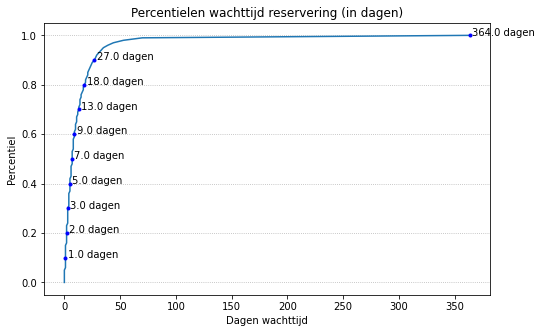

De gemiddelde wachttijd is 11.51 dagen
80% van de reserveringen wordt geleverd tussen 1.0 en 27.0 dagen
De helft van de reserveringen worden geleverd binnen de 7.0 dagen


In [10]:
# sumstats voor dagen wachttijd

sum_stats = gewoon_succes.describe(percentiles=np.arange(0.1, 1.1, 0.1))[['dagen_wacht']]
display(sum_stats.T)

# gemiddelde wachttijd als ecdf plotten
pct = gewoon_succes[['dagen_wacht']].quantile(np.linspace(0, 1, 101))

markers_y = np.arange(0.1, 1.1, 0.1)
markers_x = [gewoon_succes.quantile(y)['dagen_wacht'] for y in markers_y]


fig, ax = plt.subplots(figsize=(8,5))
plt.plot(pct['dagen_wacht'], pct.index)
for x, y in zip(markers_x, markers_y):
    s = '{} dagen'.format(round(x, 2))
    plt.plot(x, y, marker='.', color='b')
    plt.annotate(text=s, xy=(x, y), xytext=(x + 2, y))
plt.grid(axis='y', linestyle=':')
plt.title('Percentielen wachttijd reservering (in dagen)')
plt.xlabel('Dagen wachttijd')
plt.ylabel('Percentiel')
plt.show()



print('De gemiddelde wachttijd is {:.2f} dagen'.format(gewoon_succes['dagen_wacht'].mean()))
print('80% van de reserveringen wordt geleverd tussen {} en {} dagen'.format(pct.loc[0.1, 'dagen_wacht'], pct.loc[0.9, 'dagen_wacht']))
print('De helft van de reserveringen worden geleverd binnen de {} dagen'.format(pct.loc[0.5, 'dagen_wacht']))


,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
dagen_wacht,535.0,13.723585,7.362747,0.0,8.217544,9.417857,10.444548,11.392152,12.318471,13.576545,14.964418,16.742176,19.119515,107.835052,107.835052
size,562.0,1048.138790,2424.584230,0.0,7.100000,38.200000,100.000000,193.800000,339.500000,548.600000,907.700000,1307.200000,2406.200000,38458.000000,38458.000000


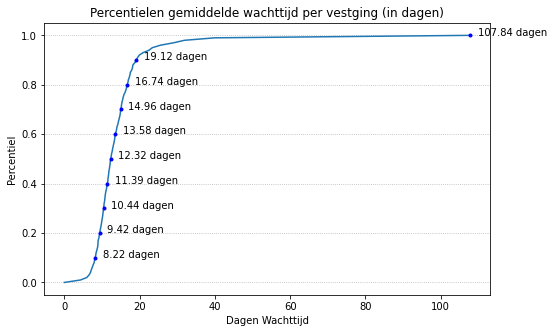

In [8]:
# gemiddelde wachttijd per vestiging

#tellen hoeveel reserveringen per vestiging & gemiddelde wachttijd per vestiging
gewoon_succes_count_vest = gewoon_succes.groupby('behrvest', as_index=False)['dagen_wacht'].size()
gewoon_succes_avg_wacht_vest = gewoon_succes.groupby('behrvest', as_index=False)['dagen_wacht'].mean()

# summary stats berekenen voor telling & gemiddelde wachttijd
sum_stats_count = gewoon_succes_count_vest.describe(percentiles=np.arange(0.1, 1.1, 0.1))
sum_stats_avg = gewoon_succes_avg_wacht_vest.describe(percentiles=np.arange(0.1, 1.1, 0.1))
sum_stats = sum_stats_avg.merge(sum_stats_count, left_index=True, right_index=True, how='outer')
display(sum_stats.T)

# gemiddelde wachttijd als ecdf plotten
pct = gewoon_succes_avg_wacht_vest.quantile(np.linspace(0, 1, 101))

markers_y = np.arange(0.1, 1.1, 0.1)
markers_x = [gewoon_succes_avg_wacht_vest.quantile(y)['dagen_wacht'] for y in markers_y]

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(pct['dagen_wacht'], pct.index)
for x, y in zip(markers_x, markers_y):
    s = '{} dagen'.format(round(x, 2))
    plt.plot(x, y, marker='.', color='b')
    plt.annotate(text=s, xy=(x, y), xytext=(x + 2, y))
plt.grid(axis='y', linestyle=':')
plt.title('Percentielen gemiddelde wachttijd per vestging (in dagen)')
plt.xlabel('Dagen Wachttijd')
plt.ylabel('Percentiel')
plt.show()
